## Imports

In [35]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re
import numpy
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import random


import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.transforms import InterpolationMode
from torchvision.transforms.functional import to_tensor
import random
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import math

import os
import numpy as np
import torch
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import random_split

from torch.utils.data import ConcatDataset, DataLoader

from scipy.stats import mode

import os
import numpy as np
import tifffile
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.stats import skew, kurtosis
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
BASE_PATH = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS = ['lombardia', 'lombardia2']
YEARS = ['data2016', 'data2017', 'data2018']
IMG_SIZE = (48, 48)
BANDS = 9

def is_valid_image(file):
    return file.endswith('.tif') and '_MSAVI' not in file and os.path.basename(file) != 'y.tif'

def load_image_stack(tile_path):
    # Load and stack all satellite images (ignore MSAVI)
    img_files = sorted([f for f in os.listdir(tile_path) if is_valid_image(f)])
    stack = []
    for f in img_files:
        with rasterio.open(os.path.join(tile_path, f)) as src:
            arr = src.read()  # shape: (9, 48, 48)
            stack.append(arr)
    return np.stack(stack)  # shape: (T, 9, 48, 48)

def load_mask(tile_path):
    y_path = os.path.join(tile_path, 'y.tif')
    with rasterio.open(y_path) as src:
        mask = src.read(1)
    return remap_labels(mask, label_remap) #(48,48) image with remapped labels


In [3]:
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

def remap_labels(mask, label_remap):
    return np.vectorize(lambda x: label_remap.get(x, 255))(mask).astype(np.uint8)


In [4]:


def plot_band_histogram(X, band=0, timestep=0, title_prefix=""):

    band_data = X[timestep, band].flatten()
    
    plt.figure(figsize=(7, 4))
    plt.hist(band_data, bins=100, color='blue', alpha=0.7)
    plt.title(f"{title_prefix} Band {band} Histogram @ t={timestep}")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()






In [5]:

band_sums = np.zeros(BANDS, dtype=np.float64)
band_sqsums = np.zeros(BANDS, dtype=np.float64)
band_counts = np.zeros(BANDS, dtype=np.int64)
all_data = []

for region in FOLDERS:
    for year in YEARS:
        tiles_root = os.path.join(BASE_PATH, region, year)
        tile_ids = sorted(os.listdir(tiles_root))

        for tile_id in tqdm(tile_ids[:2500:10], desc=f"{region}/{year}"):
            tile_path = os.path.join(tiles_root, tile_id)
            try:
                X = load_image_stack(tile_path)  # (T, 9, 48, 48)
                y = load_mask(tile_path)        # (48, 48)
                
                # Compute stats
                for b in range(BANDS):
                    band_data = X[:, b, :, :].astype(np.float64)
                    band_sums[b] += band_data.sum()
                    band_sqsums[b] += (band_data ** 2).sum()
                    band_counts[b] += band_data.size

                all_data.append((X, y))
            except Exception as e:
                print(f"❌ Failed to load {tile_path}: {e}")

# mean and std
means = band_sums / band_counts
stds = np.sqrt(band_sqsums / band_counts - means ** 2)
print("\n📊 Per-band means:", np.round(means, 2))
print("📊 Per-band stds: ", np.round(stds, 2))




lombardia2/data2018: 100%|██████████| 250/250 [03:24<00:00,  1.22it/s]


📊 Per-band means: [2936.47 3003.14 2949.34 3318.7  3911.91 4164.94 4277.07 2875.46 2234.14]
📊 Per-band stds:  [3455.82 3180.35 3097.75 3042.09 2633.58 2521.82 2565.9  1480.45 1363.43]



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 | 8274.64  468.43 6755.00 9455.00 7977.00 8265.00 8588.00   -0.26    0.23
   1 | 7683.49  456.67 6276.00 8859.00 7356.00 7669.00 7998.25   -0.07   -0.19
   2 | 7107.09  463.16 5852.00 8306.00 6748.00 7106.00 7415.25    0.07   -0.48
   3 | 7266.61  442.02 6166.00 8256.00 6924.75 7264.00 7565.00    0.07   -0.63
   4 | 7374.47  444.94 6118.00 8564.00 7054.00 7414.00 7704.00   -0.18   -0.46
   5 | 7282.92  441.95 6042.00 8466.00 6997.00 7323.00 7610.00   -0.29   -0.28
   6 | 7493.34  435.42 6197.00 8727.00 7187.00 7501.00 7811.50   -0.23   -0.15
   7 | 5393.29  323.04 4564.00 6251.00 5156.50 5393.00 5630.00   -0.01   -0.62
   8 | 4895.02  320.77 3997.00 5704.00 4660.00 4900.00 5129.00   -0.10   -0.45


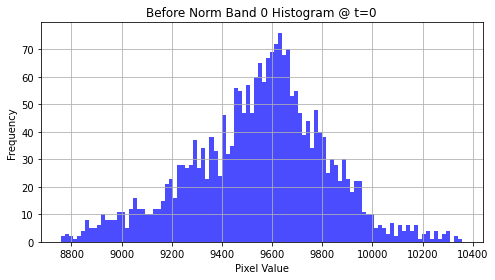

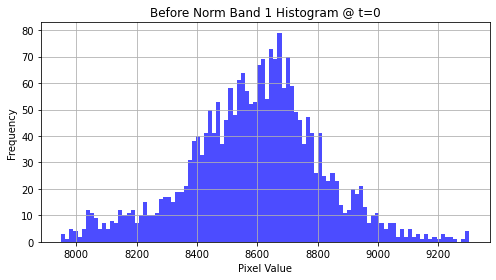

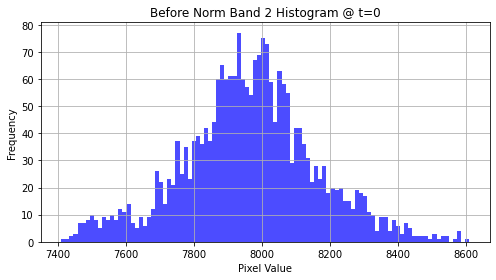

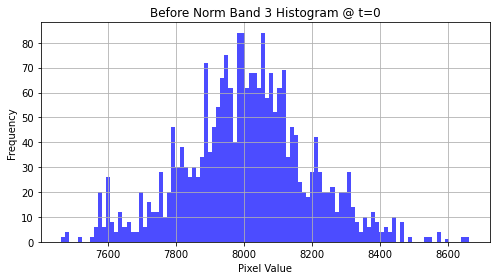

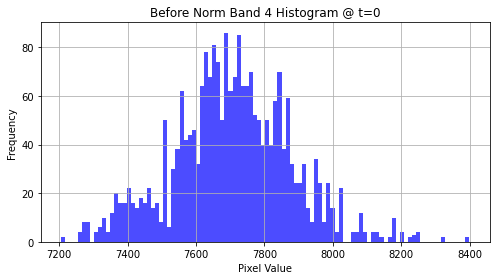

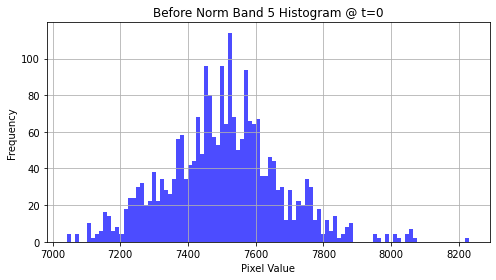

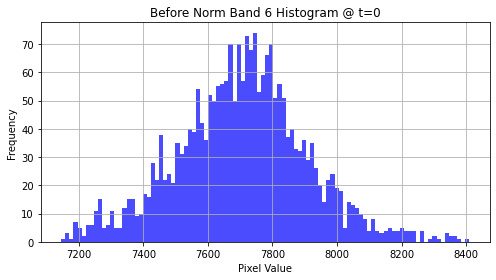

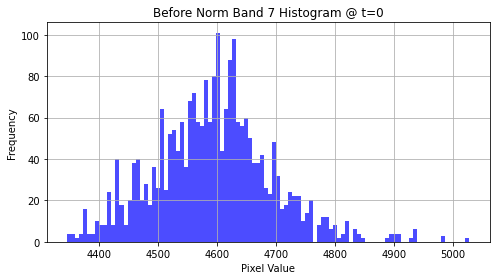

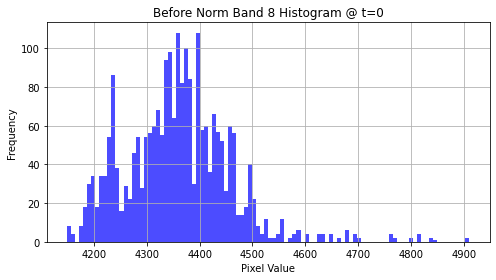

In [6]:


def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="Before Norm")

In [7]:
#Z-score normalisaiton
for i in range(len(all_data)):
    X, y = all_data[i]
    X = X.astype(np.float32)  
    for b in range(BANDS):
        X[:, b] = (X[:, b] - means[b]) / stds[b]
    all_data[i] = (X, y)



📦 Sample 0, Timestep 0, Shape: (34, 9, 48, 48)
Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt
   0 |    1.54    0.14    1.10    1.89    1.46    1.54    1.64   -0.26    0.23
   1 |    1.47    0.14    1.03    1.84    1.37    1.47    1.57   -0.07   -0.19
   2 |    1.34    0.15    0.94    1.73    1.23    1.34    1.44    0.07   -0.48
   3 |    1.30    0.15    0.94    1.62    1.19    1.30    1.40    0.07   -0.63
   4 |    1.31    0.17    0.84    1.77    1.19    1.33    1.44   -0.18   -0.46
   5 |    1.24    0.18    0.74    1.71    1.12    1.25    1.37   -0.29   -0.28
   6 |    1.25    0.17    0.75    1.73    1.13    1.26    1.38   -0.23   -0.15
   7 |    1.70    0.22    1.14    2.28    1.54    1.70    1.86   -0.01   -0.62
   8 |    1.95    0.24    1.29    2.54    1.78    1.96    2.12   -0.10   -0.45


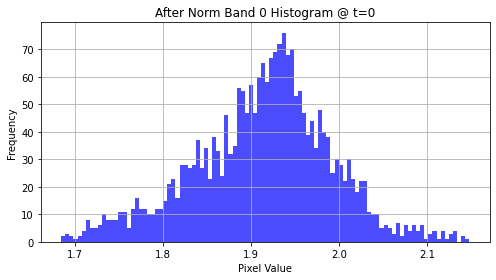

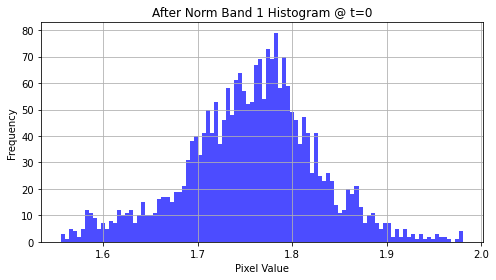

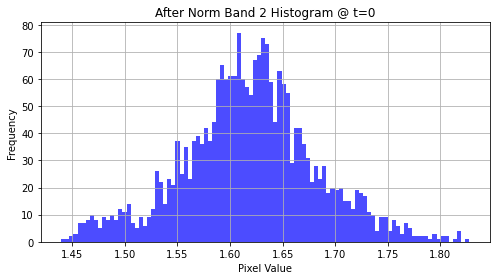

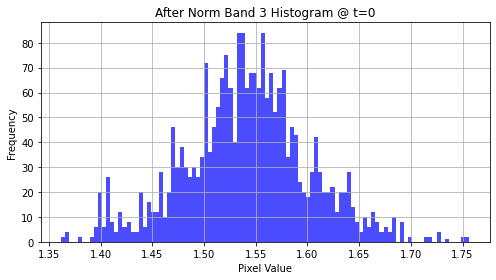

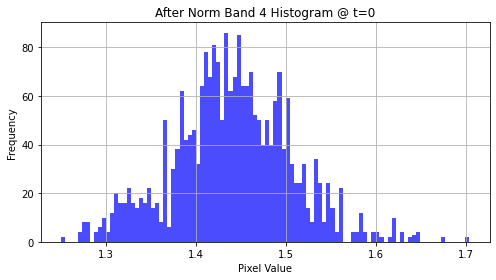

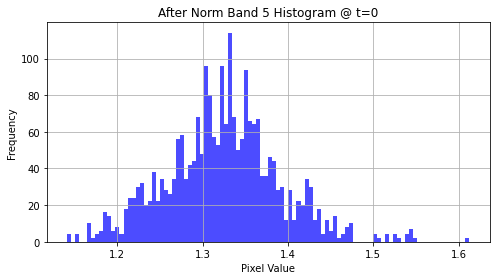

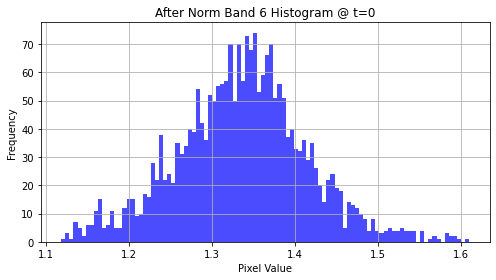

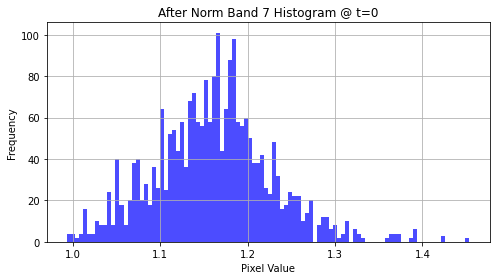

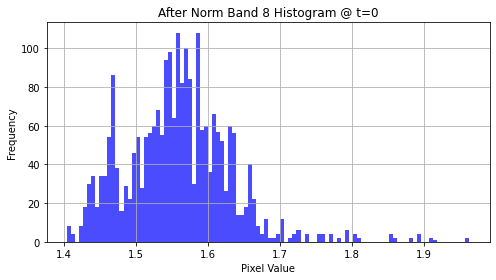

In [8]:

def print_band_summary(X, timestep=0, sample_id=0):
    print(f"\n📦 Sample {sample_id}, Timestep {timestep}, Shape: {X.shape}")
    print("Band | Mean     Std     Min     Max     P25     P50     P75     Skew   Kurt")

    for b in range(X.shape[1]):
        band_data = X[timestep, b].astype(np.float64).flatten()
        mean = band_data.mean()
        std = band_data.std()
        vmin = band_data.min()
        vmax = band_data.max()
        p25 = np.percentile(band_data, 25)
        p50 = np.percentile(band_data, 50)
        p75 = np.percentile(band_data, 75)
        sk = skew(band_data)
        kurt = kurtosis(band_data)
        
        print(f"{b:>4} | {mean:7.2f} {std:7.2f} {vmin:7.2f} {vmax:7.2f} {p25:7.2f} {p50:7.2f} {p75:7.2f} {sk:7.2f} {kurt:7.2f}")

# Example usage:
X, y = all_data[0]
print_band_summary(X, timestep=0, sample_id=0)

for b in range(9):  # for all 9 bands
    X, _ = all_data[13]
    plot_band_histogram(X, band=b, timestep=0, title_prefix="After Norm")

In [9]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())



# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 3456000
📊 Label Frequencies:
  Label 0: 291407 pixels
  Label 1: 730362 pixels
  Label 2: 781280 pixels
  Label 3: 311628 pixels
  Label 4: 516137 pixels
  Label 5: 275921 pixels
  Label 6: 549265 pixels


In [10]:

label_counter = Counter()

for _, mask in all_data:
    unique, counts = np.unique(mask, return_counts=True)
    label_counter.update(dict(zip(unique, counts)))

print("Class pixel counts:", dict(label_counter))

num_classes = 7
total_pixels = sum(label_counter.values())

weights = []
for cls in range(num_classes):
    cls_count = label_counter.get(cls, 0)
    if cls_count == 0:
        weights.append(0.0)  # Unused class
    else:
        freq = cls_count / total_pixels
        weights.append(1.0 / freq)

# Step 5: Convert to torch.Tensor
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights:", class_weights)


Class pixel counts: {0: 291407, 1: 730362, 3: 311628, 4: 516137, 5: 275921, 6: 549265, 2: 781280}
Class weights: tensor([11.8597,  4.7319,  4.4235, 11.0901,  6.6959, 12.5253,  6.2920],
       device='cuda:0')


In [11]:
#fixed seed
np.random.seed(13)

#80/20 split
total_len = len(all_data)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_raw, val_raw = random_split(all_data, [train_len, val_len])

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_raw)}")
print(f"Test samples:  {len(val_raw)}")

Total samples: 1500
Train samples: 1200
Test samples:  300


In [12]:

def analyze_timesteps(data):
    timestep_counts = defaultdict(int)

    for X, _ in data:
        T = X.shape[0]
        timestep_counts[T] += 1

    # Print detailed info
    print("📊 Unique Time Step Counts:")
    for T in sorted(timestep_counts):
        print(f"  T = {T}: {timestep_counts[T]} tiles")

    print(f"\n🧮 Total Unique T values: {len(timestep_counts)}")
    return timestep_counts

# Example usage
analyze_timesteps(train_raw)



📊 Unique Time Step Counts:
  T = 33: 191 tiles
  T = 34: 202 tiles
  T = 53: 405 tiles
  T = 68: 202 tiles
  T = 71: 200 tiles

🧮 Total Unique T values: 5


defaultdict(int, {53: 405, 71: 200, 68: 202, 33: 191, 34: 202})

Image sequence shape: (34, 9, 48, 48)
Ground truth shape: (48, 48)


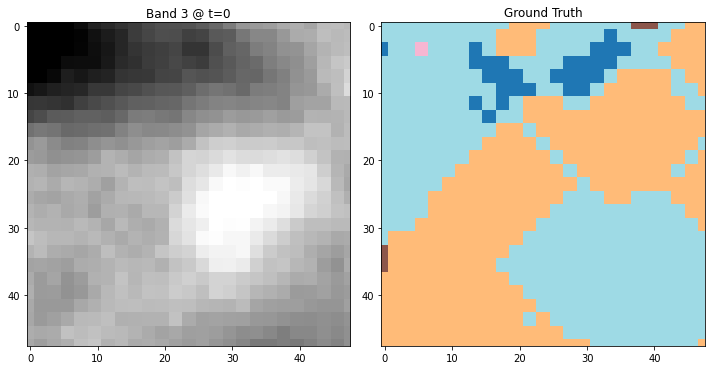

In [13]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    img = X[timestep, band]
    
    # Normalize visualization range to make contrast visible
    vmin = np.percentile(img, 2)
    vmax = np.percentile(img, 98)

    axs[0].imshow(img, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0].set_title(f'Band {band} @ t={timestep}')

    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')

    plt.tight_layout()
    plt.show()


# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, timestep=0, band=3)


# Model

In [47]:
class CNN(nn.Module):
    def __init__(self, in_channels=32*9, num_classes=7, dropout=0.3):
        super().__init__()

        def res_block(in_ch, out_ch, dilation):
            skip = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(),
                nn.Dropout2d(dropout),
                nn.Conv2d(out_ch, out_ch, 3, padding=dilation, dilation=dilation),
                nn.BatchNorm2d(out_ch),
                nn.Dropout2d(dropout),
                nn.ReLU(),
                nn.Sequential(skip)  # identity if same shape, otherwise 1x1 conv
            )

        self.encoder1 = res_block(in_channels, 256, dilation=1)
        self.encoder2 = res_block(256, 256, dilation=2)
        self.encoder3 = res_block(256, 256, dilation=4)
        self.encoder4 = res_block(256, 512, dilation=2)
        self.encoder5 = res_block(512, 512, dilation=1)
        self.final_conv = nn.Conv2d(512, num_classes, kernel_size=1)

    def forward(self, x):
        # Manual forward pass for residual + skip connections
        def forward_res_block(x, block):
            skip = block[-1][0](x)
            out = block[0](x)
            out = block[1](out)
            out = block[2](out)
            out = block[3](out)
            out = block[4](out)
            out = block[5](out)
            out = block[6](out)
            return F.relu(out + skip)

        x = forward_res_block(x, self.encoder1)
        x = forward_res_block(x, self.encoder2)
        x = forward_res_block(x, self.encoder3)
        x = forward_res_block(x, self.encoder4)
        x = forward_res_block(x, self.encoder5)
        return self.final_conv(x)


In [45]:

class CustomDataset(Dataset):
    def __init__(self, tiles, label_smoothing=0.1, num_classes=7, augment=False, noise_std=0.01):
        self.tiles = tiles
        self.augment = augment
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.noise_std = noise_std

        self.aug = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, interpolation=InterpolationMode.BILINEAR),
        ])

    def __len__(self):
        return len(self.tiles)

    def __getitem__(self, idx):
        X, y = self.tiles[idx]  # X: (32, 9, 48, 48), y: (48, 48)
        X = X.reshape(-1, 48, 48)  # (32*9, 48, 48)

        if self.augment:
            seed = random.randint(0, 99999)
            torch.manual_seed(seed)
            X = self.aug(X)
            torch.manual_seed(seed)
            y = self.aug(y.unsqueeze(0)).squeeze(0).long()

        #gaussian noise
        X = X + torch.randn_like(X) * self.noise_std

        return X.float(), y.long()  

def get_dataloaders(train_tiles, val_tiles, batch_size=16):
    train_ds = CustomDataset(train_tiles, augment=True)
    val_ds = CustomDataset(val_tiles, augment=False)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader


# Training

In [49]:
T=32
num_epochs = 10
lr = 1e-3
weight_decay = 1e-4
label_smoothing = 0.1


model = CNN(in_channels=T*9, num_classes=7).to(device) 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

# --- Training Loop ---
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for X, y in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()

    train_losses.append(total_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"[Val] Epoch {epoch+1}/{num_epochs}", leave=False):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = criterion(logits, y)
            val_loss += loss.item()
            pred = logits.argmax(1)
            val_correct += (pred == y).sum().item()
            val_total += y.numel()

    val_losses.append(val_loss / len(val_loader))
    val_accs.append(100 * val_correct / val_total)
    scheduler.step()

    print(f"Epoch {epoch+1:02d} | Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | "
          f"Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")




[Train] Epoch 1/10: 100%|██████████| 75/75 [00:38<00:00,  1.96it/s]


Epoch 01 | Train Loss: 1.9183 | Val Loss: 1.7489 | Train Acc: 31.89% | Val Acc: 31.59%


[Train] Epoch 2/10: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 02 | Train Loss: 1.6908 | Val Loss: 1.5695 | Train Acc: 39.69% | Val Acc: 46.46%


[Train] Epoch 3/10: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s]


Epoch 03 | Train Loss: 1.5625 | Val Loss: 1.4412 | Train Acc: 46.66% | Val Acc: 54.55%


[Train] Epoch 4/10: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 04 | Train Loss: 1.4609 | Val Loss: 1.3990 | Train Acc: 52.14% | Val Acc: 54.65%


[Train] Epoch 5/10: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s]


Epoch 05 | Train Loss: 1.3899 | Val Loss: 1.3306 | Train Acc: 55.89% | Val Acc: 59.05%


[Train] Epoch 6/10: 100%|██████████| 75/75 [00:38<00:00,  1.95it/s]


Epoch 06 | Train Loss: 1.3173 | Val Loss: 1.2803 | Train Acc: 59.41% | Val Acc: 62.20%


[Train] Epoch 7/10: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 07 | Train Loss: 1.2892 | Val Loss: 1.2558 | Train Acc: 61.25% | Val Acc: 63.60%


[Train] Epoch 8/10: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 08 | Train Loss: 1.2677 | Val Loss: 1.2507 | Train Acc: 62.39% | Val Acc: 64.10%


[Train] Epoch 9/10: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]


Epoch 09 | Train Loss: 1.2485 | Val Loss: 1.2355 | Train Acc: 63.58% | Val Acc: 64.52%


[Train] Epoch 10/10: 100%|██████████| 75/75 [00:38<00:00,  1.94it/s]
                                                                  

Epoch 10 | Train Loss: 1.2309 | Val Loss: 1.2258 | Train Acc: 64.43% | Val Acc: 65.22%


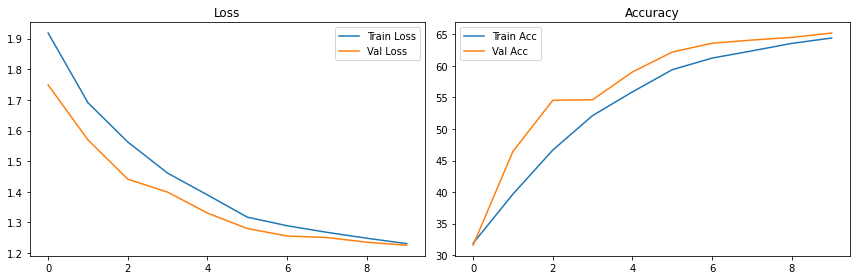

In [50]:
# --- Plotting ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evalutaion

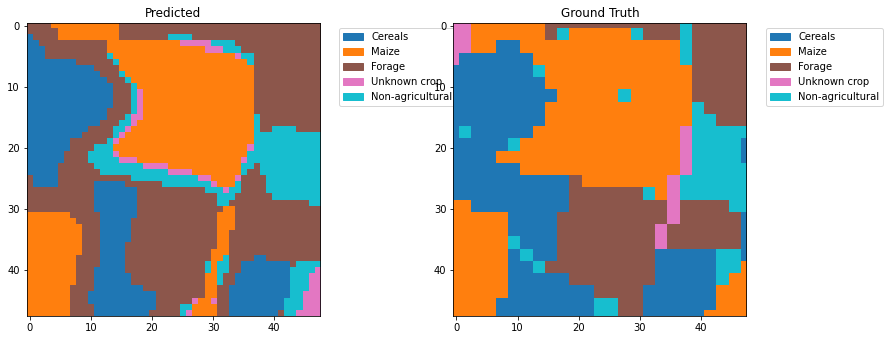

🔍 Evaluating 300 samples

📊 Ground Truth Pixel Count Per Class (Total):
  Cereals: 54824
  Maize: 147485
  Rice: 169144
  Forage: 63172
  Unknown crop: 95810
  Woods/tree crops: 58598
  Non-agricultural: 102167

🤖 Predicted Pixel Count Per Class (Total):
  Cereals: 57879
  Maize: 160220
  Rice: 203829
  Forage: 62120
  Unknown crop: 60864
  Woods/tree crops: 66940
  Non-agricultural: 79348

✅ Per-pixel Accuracy (Total): 0.6522


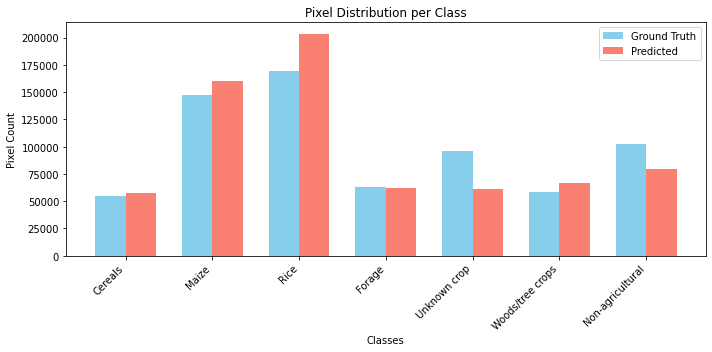

In [51]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None):
    import matplotlib.patches as mpatches

    model.eval()
    X, y = dataset[idx]
    X = X.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(X).argmax(1).squeeze().cpu().numpy()
    
    y = y.numpy()

    pred_classes = np.unique(pred)
    gt_classes = np.unique(y)

    # Create color map and legends with names
    cmap = plt.cm.get_cmap('tab10', num_classes)
    pred_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in pred_classes]
    gt_legend = [mpatches.Patch(color=cmap(cls), label=label_names[cls]) for cls in gt_classes]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(pred, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title("Predicted")
    plt.legend(handles=pred_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    plt.imshow(y, cmap=cmap, vmin=0, vmax=num_classes-1)
    plt.title("Ground Truth")
    plt.legend(handles=gt_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()



def evaluate_combined(model, loader, label_names, num_classes=7):
    model.eval()
    pred_counts = np.zeros(num_classes, dtype=int)
    gt_counts = np.zeros(num_classes, dtype=int)
    correct = 0
    total = 0

    with torch.no_grad():
        print(f"🔍 Evaluating {len(loader.dataset)} samples")
        for X, y in loader:
            X, y = X.to(device), y.to(device)  # X: (B, 288, 48, 48), y: (B, 48, 48)
            preds = model(X).argmax(1)        # (B, 48, 48)

            preds_np = preds.cpu().numpy().flatten()
            y_np = y.cpu().numpy().flatten()

            for cls in range(num_classes):
                pred_counts[cls] += np.sum(preds_np == cls)
                gt_counts[cls] += np.sum(y_np == cls)

            correct += np.sum(preds_np == y_np)
            total += y_np.size

    print("\n📊 Ground Truth Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {gt_counts[cls]}")

    print("\n🤖 Predicted Pixel Count Per Class (Total):")
    for cls in range(num_classes):
        print(f"  {label_names[cls]}: {pred_counts[cls]}")

    acc = correct / total
    print(f"\n✅ Per-pixel Accuracy (Total): {acc:.4f}")

    # === Plotting the distributions ===
    class_names = [label_names[cls] for cls in range(num_classes)]

    plt.figure(figsize=(10, 5))
    bar_width = 0.35
    x = np.arange(num_classes)

    plt.bar(x - bar_width/2, gt_counts, bar_width, label='Ground Truth', color='skyblue')
    plt.bar(x + bar_width/2, pred_counts, bar_width, label='Predicted', color='salmon')

    plt.xlabel("Classes")
    plt.ylabel("Pixel Count")
    plt.title("Pixel Distribution per Class")
    plt.xticks(x, class_names, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}



visualize(model, train_dataset, idx=8, num_classes=7, label_names=label_names)
evaluate_combined(model, val_loader, label_names, num_classes=7)




# Loading Model

In [ ]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)
